# FYS-STK4155 - Project 1

We are going to compare the linear regression methods Ordinary Least Squares (OLS) method, Ridge regression and Lasso regression. To do this we are going to fit them to the Franke function and terrain data and evaluate them using the resampling methods bootstrap and cross validation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

import sklearn.linear_model as skl
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.utils import resample, shuffle

from numba import jit

We are starting off by fitting the franke function:

$$
\begin{align*}
f(x,y) &= \frac{3}{4}\exp{\left(-\frac{(9x-2)^2}{4} - \frac{(9y-2)^2}{4}\right)}+\frac{3}{4}\exp{\left(-\frac{(9x+1)^2}{49}- \frac{(9y+1)}{10}\right)} \\
&+\frac{1}{2}\exp{\left(-\frac{(9x-7)^2}{4} - \frac{(9y-3)^2}{4}\right)} -\frac{1}{5}\exp{\left(-(9x-4)^2 - (9y-7)^2\right) }.
\end{align*}
$$

In [2]:
def franke(x, y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

## Visualization of Franke Function

Before we do any linear regression, we should plot the franke function to make sure the function is defined properly and that the function is suited to a polynomial fit.

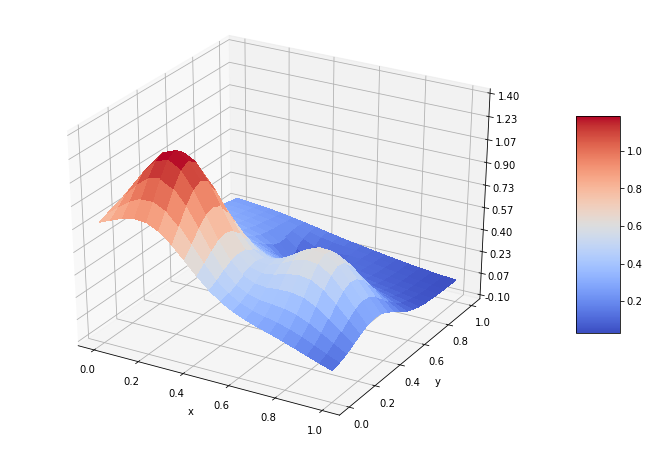

In [3]:
# Make data
x = np.linspace(0, 1, 20)
y = np.linspace(0, 1, 20)
x, y = np.meshgrid(x, y)

z = franke(x, y)

# Plot the surface
fig = plt.figure(figsize = (12, 8))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm, linewidth=0, antialiased=False)

# Customize the axes
ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
plt.xlabel("x")
plt.ylabel("y")

# Add a color bar which maps values to colors
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

## Setup of data

We are going to set up data for fitting many times this project, so we should define functions for generating data, creating a design matrix, and scaling the design matrix.

We are going to use polynomials of x and y to fit the data. If we want to use a fifth order polynomial, the possible terms in the polynomial are multiples of the following terms:

$$
\begin{equation}
\begin{aligned}
& 1\;\;\;   x\;\;\;\;\;    x^2\;\;\;   x^3\;\;\;\;   x^4\;\;  x^5 \\
& y\;\;\;   yx\;\;\;  yx^2\;\;  yx^3\;\;  yx^4 \\
& y^2\;  y^2x\;  y^2x^2\;  y^2x^3 \\
& y^3\;  y^3x\;  y^3x^2 \\
& y^4\;  y^4x \\
& y^5 \\
\end{aligned}
\end{equation}
$$

Depending on the order of the polynomial, we get a different number of parameters for the fit. The number of parameters p is given by the function:

In [4]:
def pval(order):
    return int((order + 1) * (order + 2) / 2)

In [5]:
print(pval(5))

21


`designMatrix()` creates the design matrix by evaluating all of these terms in the polynomial as a function of input vectors x and y.

In [6]:
@jit #makes the function faster
def designMatrix(x, y, order):
    n = x.size
    p = int((order + 1) * (order + 2) / 2) # number of columns in X (can't use the function pval() due to @jit)
    X = np.zeros((n, p))
    feature = 0
    for x_power in range(order + 1):
        for y_power in range(order - x_power + 1):
            X[:, feature] = x**x_power * y**y_power
            feature += 1
    return X

`data()` generates datapoints from the franke function with noise at random points (x, y), and returns the design matrix and z-values. We found that n = 100 is few enough datapoints to see overfitting, so we will use 100 datapoints for the franke function for the rest of this notebook.

In [7]:
n = 100 # datapoints
def data(n, order):
    x = np.random.rand(n) #an array of n unordered uniform random numbers from 0 to 1
    y = np.random.rand(n)
    noise = np.random.randn(n) / 10
    
    z = franke(x, y) + noise
    X = designMatrix(x, y, order)
    
    return X, z

`scale()` scales training and test data according to the training data.

In [8]:
def scale(X_train, X_test):
    scaler = StandardScaler() #subtracts mean from each feature and divides by the standard deviation
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_train[:, 0] = 1 # scaling removed the intercept terms
    X_test = scaler.transform(X_test)
    X_test[:, 0] = 1
    return X_train, X_test

## Regression methods

Functions for finding the optimal parameters with our three regression methods.

In [9]:
def OLS(X, z, lmda=None, p=None):
    beta = np.linalg.inv(X.T @ X) @ X.T @ z
    return beta

def ridge(X, z, lmda, p):
    beta = np.linalg.inv(X.T @ X + lmda * np.eye(p)) @ X.T @ z
    return beta

def lasso(X, z, lmda, p):
    clf = skl.Lasso(lmda, max_iter = 10000)
    clf.fit(X,z)
    return clf.coef_

## Part a): Ordinary Least Square (OLS) on the Franke function 

We fit the data using OLS to find the optimal coefficients of a fifth order polynomial in x and y. We find the mean squared error on the training and test data, together with the R2-score and the confidence intervals of the parameters.

In [31]:
# Setup of data
order = 5 # max order of polynomials
X, z = data(n, order)
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size = 0.2)
X_train, X_test = scale(X_train, X_test)
# OLS regression
beta = OLS(X_train, z_train)
# Evaluation of model
z_mdl = X_test @ beta
print(f"Mean squared error on training data = {mean_squared_error(X_train @ beta, z_train):.4f}")
print(f"Mean squared error = {mean_squared_error(z_mdl, z_test):.4f}")
print(f"R2 score = {r2_score(z_mdl, z_test):.4f}")
print("Coefficients with 95% confidence intervals:")
betaVar = np.linalg.inv(X_train.T @ X_train)
for i in range(pval(order)):
    std = betaVar[i, i]**0.5
    print(f"B_{i+1} = {beta[i]:.2f} +- {1.96 * std:.2f}")

Mean squared error on training data = 0.0110
Mean squared error = 0.0127
R2 score = 0.8664
Coefficients with 95% confidence intervals:
B_1 = 0.39 +- 0.13
B_2 = 1.23 +- 7.96
B_3 = -3.05 +- 36.82
B_4 = -0.70 +- 78.01
B_5 = 5.63 +- 76.85
B_6 = -3.17 +- 28.50
B_7 = 3.48 +- 10.32
B_8 = -3.41 +- 24.92
B_9 = 3.21 +- 40.72
B_10 = -4.17 +- 36.12
B_11 = 2.40 +- 15.53
B_12 = -16.46 +- 48.94
B_13 = 8.95 +- 46.70
B_14 = -1.03 +- 36.46
B_15 = -1.02 +- 14.19
B_16 = 27.03 +- 98.93
B_17 = -9.70 +- 43.02
B_18 = 1.56 +- 13.17
B_19 = -19.12 +- 92.86
B_20 = 3.21 +- 16.01
B_21 = 4.88 +- 33.00


## Part b): Bias-variance trade-off and resampling techniques

Before we analyze the bias-variance tradeoff with bootstrap resampling, we compare training and test MSE as a function of model complexity. 

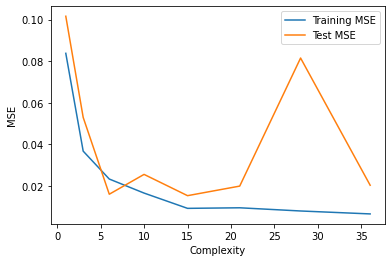

In [11]:
max_order = 7
p_arr = [pval(i) for i in range(max_order + 1)]

training_mse = np.zeros(len(p_arr))
test_mse = np.zeros(len(p_arr))

for i in range(max_order+1):
    X, z = data(n, i)
    X_train, X_test, z_train, z_test = train_test_split(X, z, test_size = 0.2)
    X_train, X_test = scale(X_train, X_test)
    beta = OLS(X_train, z_train)
    # Evaluation of model
    training_mse[i] = mean_squared_error(X_train @ beta, z_train)
    test_mse[i] = mean_squared_error(X_test @ beta, z_test)

plt.plot(p_arr, training_mse, label='Training MSE')
plt.plot(p_arr, test_mse, label='Test MSE')
plt.legend()
plt.xlabel("Complexity")
plt.ylabel("MSE")
plt.show()

A more robust way to evaluate the MSE of a model is to use resampling. We first implement bootstrap resampling. `bootBiasVar()` splits and scales the data X and z, does `n_bootstraps` bootstraps on the training data, and returns the mean squared error, bias and variance of the model using a polynomial of a given order `order` and regression function `reg_func`. We will use this function throughout this notebook to analyze the bias-variance tradeoff for different parameters.

In [12]:
def bootBiasVar(n_boostraps, X, z, order, reg_func, lmda=0):
    X_train, X_test, z_train, z_test = train_test_split(X, z, test_size = 0.2)
    X_train, X_test = scale(X_train, X_test)
    
    z_pred = np.empty((n_boostraps, z_test.size))
    for i in range(n_boostraps):
        X_, z_ = resample(X_train, z_train)
        z_pred[i] = X_test @ reg_func(X_, z_, lmda, pval(order))

    mse = np.mean( np.mean((z_test - z_pred)**2, axis=0, keepdims=True) )
    bias = np.mean( (z_test - np.mean(z_pred, axis=0, keepdims=True))**2 )
    var = np.mean( np.var(z_pred, axis=0, keepdims=True) )
    
    return mse, bias, var

### Bias-variance tradeoff for polynomial order

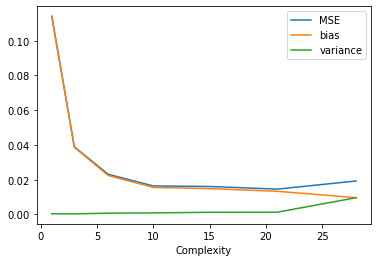

In [33]:
n_boostraps = 20
max_order = 6
p_arr = [pval(i) for i in range(max_order + 1)]

mse_arr = np.zeros(len(p_arr))
bias_arr = np.zeros(len(p_arr))
var_arr = np.zeros(len(p_arr))
for j in range(max_order+1):
    X, z = data(n, j)
    mse_arr[j], bias_arr[j], var_arr[j] = bootBiasVar(n_boostraps, X, z, j, OLS)

plt.plot(p_arr, mse_arr, label='MSE')
plt.plot(p_arr, bias_arr, label='bias')
plt.plot(p_arr, var_arr, label='variance')
plt.xlabel("Complexity")
plt.legend()
plt.show()

### Bias-variance tradeoff for the number of datapoints

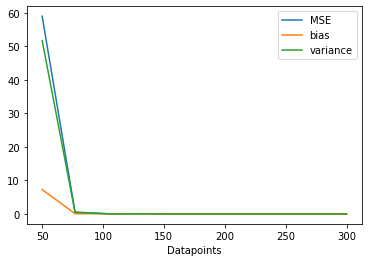

In [34]:
n_boostraps = 20
order = 5
n_arr = np.linspace(50, 300, 10, dtype=int)

mse_arr = np.zeros(len(n_arr))
bias_arr = np.zeros(len(n_arr))
var_arr = np.zeros(len(n_arr))
for j, n in enumerate(n_arr):
    X, z = data(n, order)
    mse_arr[j], bias_arr[j], var_arr[j] = bootBiasVar(n_boostraps, X, z, order, OLS)

plt.plot(n_arr, mse_arr, label='MSE')
plt.plot(n_arr, bias_arr, label='bias')
plt.plot(n_arr, var_arr, label='variance')
plt.xlabel('Datapoints')
plt.legend()
plt.show()

## Part c): Cross-validation as resampling techniques, adding more complexity

Huske å begrunne hvorfor vi bruker/ikke bruker validation.



In [15]:
def split(data, k):
    n = len(data)
    fold_size = n // k #standard fold size, will be one larger if we need to get rid of extra elements
    test_start = 0
    extra = n % k #the first extra folds need one more element
    
    fold_indexes = []
    for i in range(k):
        if extra > 0:
            test_size = fold_size + 1
            extra -= 1
        else:
            test_size = fold_size
        training_size = n - test_size
        test_stop = test_start + test_size
        
        training_indexes = np.zeros(training_size, dtype=int)
        training_indexes[:test_start] = np.array(range(0, test_start)) #before testing
        training_indexes[test_start:] = np.array(range(test_stop, n)) #after testing
 
        testing_indexes = np.array(range(test_start, test_stop))

        fold_indexes.append([training_indexes, testing_indexes])
        test_start += test_size
        
    return fold_indexes

In [16]:
def CV_mse(X, z, order, k, reg_func, lmda=0):
    MSE = 0
    for train_inds, test_inds in split(X, k):
        X_train = X[train_inds]
        X_test = X[test_inds]
        X_train, X_test = scale(X_train, X_test)

        z_train = z[train_inds]
        z_test = z[test_inds]

        beta = reg_func(X_train, z_train, lmda, pval(order))
        z_mdl = X_test @ beta
        MSE += mean_squared_error(z_mdl, z_test) / k
    return MSE

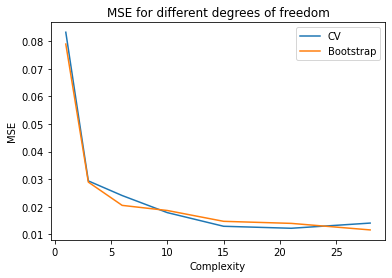

In [17]:
max_order = 6
p_arr = [pval(i) for i in range(max_order + 1)]
k = 10
mse_arr = np.zeros(len(p_arr))

n_boostraps = 10
bootstrap_mse_arr = np.zeros(len(p_arr))

for j in range(max_order + 1):
    X, z = data(n, j)
    mse_arr[j] = CV_mse(X, z, j, k, OLS)
    bootstrap_mse_arr[j] = bootBiasVar(n_boostraps, X, z, j, OLS)[0]


plt.plot(p_arr, mse_arr, label="CV")
plt.plot(p_arr, bootstrap_mse_arr, label="Bootstrap")
plt.title('MSE for different degrees of freedom')
plt.xlabel('Complexity')
plt.ylabel('MSE')
plt.legend()
plt.show()

## Part d): Ridge Regression on the Franke function with resampling

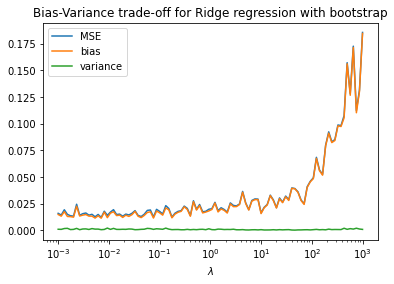

In [18]:
# bootstrap analysis for different values of lambda
lmda = np.logspace(-3,3,100)
n_boostraps = 20
order = 8

mse_arr = np.zeros(len(lmda))
bias_arr = np.zeros(len(lmda))
var_arr = np.zeros(len(lmda))

for i,l in enumerate(lmda):
    X, z = data(n, order)
    mse_arr[i], bias_arr[i], var_arr[i] = bootBiasVar(n_boostraps, X, z, order, ridge,l)

plt.plot(lmda, mse_arr, label='MSE')
plt.plot(lmda, bias_arr, label='bias')
plt.plot(lmda, var_arr, label='variance')
plt.xlabel(r'$\lambda$')
plt.title('Bias-Variance trade-off for Ridge regression with bootstrap')
plt.legend()
plt.xscale("log")
plt.show()

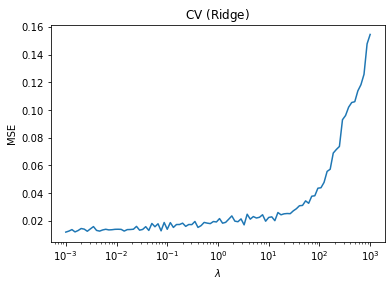

In [19]:
# CV for different values of lambda
lmda = np.logspace(-3,3,100)
order = 8
mse_arr = np.zeros(len(lmda))
k = 10

for i,l in enumerate(lmda):
    X, z = data(n, order)
    mse_arr[i] = CV_mse(X, z, order, k, ridge,l)

plt.plot(lmda, mse_arr)
plt.title(r'CV $($Ridge$)$')
plt.xlabel(r'$\lambda$')
plt.ylabel('MSE')
plt.xscale("log")
plt.show()

## Part e): Lasso Regression on the Franke function with resampling

/Users/gullatorvund/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003949867273835395, tolerance: 0.0025144829918137177
  model = cd_fast.enet_coordinate_descent(


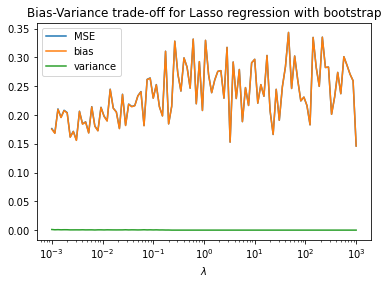

In [20]:
# bootstrap analysis for different values of lambda
lmda = np.logspace(-3,3,100)
n_boostraps = 20
order = 8

mse_arr = np.zeros(len(lmda))
bias_arr = np.zeros(len(lmda))
var_arr = np.zeros(len(lmda))

for i,l in enumerate(lmda):
    X, z = data(n, order)
    mse_arr[i], bias_arr[i], var_arr[i] = bootBiasVar(n_boostraps, X, z, order, lasso,l)

plt.plot(lmda, mse_arr, label='MSE', )
plt.plot(lmda, bias_arr, label='bias')
plt.plot(lmda, var_arr, label='variance')
plt.xlabel(r'$\lambda$')
plt.title('Bias-Variance trade-off for Lasso regression with bootstrap')
plt.legend()
plt.xscale("log")
plt.show()

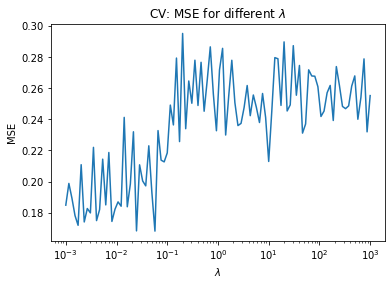

In [21]:
# CV for different values of lambda
lmda = np.logspace(-3,3,100)
order = 8
mse_arr = np.zeros(len(lmda))
k = 10

for i,l in enumerate(lmda):
    X, z = data(n, order)
    mse_arr[i] = CV_mse(X, z, order, k, lasso,l)

plt.plot(lmda, mse_arr)
plt.title(r'CV: MSE for different $\lambda$')
plt.xlabel(r'$\lambda$')
plt.ylabel('MSE')
plt.xscale("log")
plt.show()

In [22]:
CV_mse(X, z, order, k, OLS,l)

0.015222867555263241

## Part f): Introducing real data and preparing the data analysis

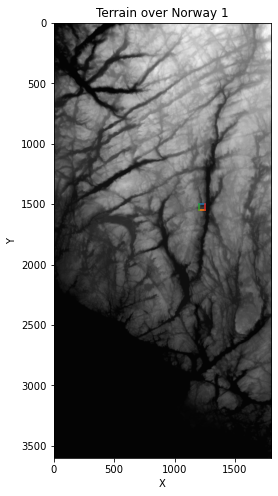

In [23]:
from imageio import imread
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# Load the terrain
terrain = imread('SRTM_data_Norway_2.tif')
# Show the terrain
plt.figure(figsize=(4,8))
plt.title('Terrain over Norway 1')
plt.imshow(terrain, cmap='gray')
plt.xlabel('X')
plt.ylabel('Y')
x1 = 1200
x2 = 1250
y1 = 1500
y2 = 1550
plt.plot([x1,x2], [y1, y1])
plt.plot([x1,x2], [y2, y2])
plt.plot([x1,x1], [y1, y2])
plt.plot([x2,x2], [y1, y2])
plt.show()

In [24]:
# The part of the data we will use for the analysis
z_grid = terrain[y1:y2, x1:x2]
# x and y values corresponding to z values
x_grid = np.linspace(0, 1, np.shape(z_grid)[1])
y_grid = np.linspace(0, 1, np.shape(z_grid)[0])
x_grid, y_grid = np.meshgrid(x_grid, y_grid)
# Arrays used for analysis
z = z_grid.ravel()
x = x_grid.ravel()
y = y_grid.ravel()
z, x, y = shuffle(z, x, y)

In [25]:
z_grid.shape

(50, 50)

## 3d plot

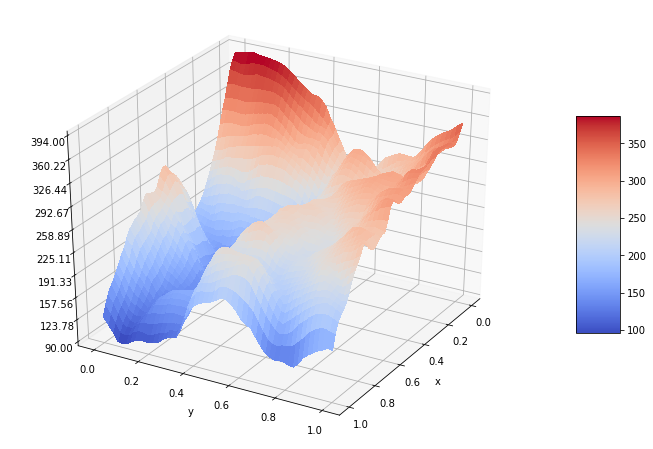

In [26]:
# Plot the surface
fig = plt.figure(figsize = (12, 8))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(x_grid, y_grid, z_grid, cmap=cm.coolwarm, linewidth=0, antialiased=False)

# Customize the axes
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
plt.xlabel("x")
plt.ylabel("y")

# Add a color bar which maps values to colors
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.view_init(30, 30)
plt.show()

## Part g) OLS, Ridge and Lasso regression with resampling

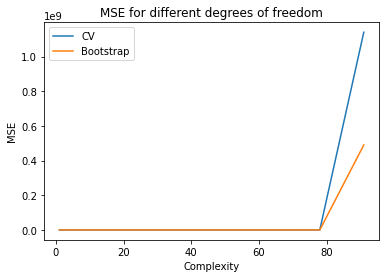

In [27]:
max_order = 12
p_arr = [pval(i) for i in range(max_order + 1)]
k = 10
mse_arr = np.zeros(len(p_arr))

n_boostraps = 10
bootstrap_mse_arr = np.zeros(len(p_arr))

for j in range(max_order + 1):
    X = designMatrix(x, y, j)
    mse_arr[j] = CV_mse(X, z, j, k, OLS)
    bootstrap_mse_arr[j] = bootBiasVar(n_boostraps, X, z, j, OLS)[0]


plt.plot(p_arr, mse_arr, label="CV")
plt.plot(p_arr, bootstrap_mse_arr, label="Bootstrap")
plt.title('MSE for different degrees of freedom')
plt.xlabel('Complexity')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [28]:
order = 5 # max order of polynomials
# Setup of data
X = designMatrix(x, y, order)
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size = 0.2)
X_train, X_test = scale(X_train, X_test)
# OLS regression
beta = OLS(X_train, z_train)
z_mdl = X_test @ beta
print(mean_squared_error(z_mdl, z_test))

270.00998359296557
